# Clean data

* 1️⃣ Resize images e.g., to (244,244,3)

* 2️⃣ Define X and y for each disease or normal GI image

* 3️⃣ Extras: remove text, remove green or black box from images

Packages to import

In [2]:
# Data analysis
import pandas as pd
import numpy as np

# Importing data and image analysis
import cv2
import os
import imutils
import skimage

# Data viz
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

Function to import data using cv2 from raw_data folder

In [3]:
def load_images_from_folder(folder):
    
    images = []
    
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    
    return images

In [4]:
train_norm_folder = "/home/mai/code/FlorenceBoutin/GI_disease_detection/raw_data/train/0_normal/"

In [5]:
train_normal = load_images_from_folder(train_norm_folder)

In [8]:
type(train_normal)

list

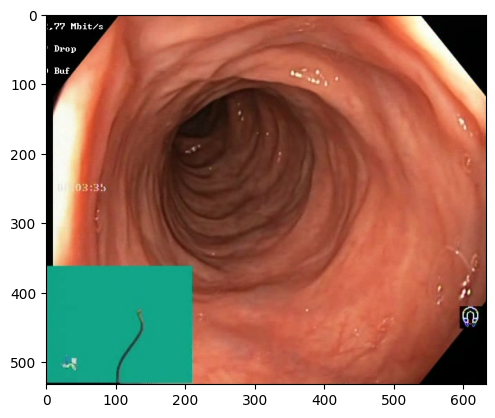

In [8]:
# plt.imshow(np.array(train_normal[0]),cmap="gray", vmin=0, vmax=255);
plt.imshow(np.array(train_normal[0]));

### Trying to removing the box - Attempt 1 [Horizontal, Vertical line approach]

Identify the lines \
Identify the box \
Fill the box with "-1" and ignore these values when we process

In [12]:
# https://stackoverflow.com/questions/57961119/how-to-remove-all-the-detected-lines-from-the-original-image-using-python

image = train_normal[0]
# gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

In [14]:
# Recognize horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(10,1))
detected_lines = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,
                                  horizontal_kernel,iterations=2)
contours = cv2.findContours(detected_lines,cv2.RETR_EXTERNAL,
                           cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

for c in contours:
    cv2.drawContours(image, [c], -1, (255,255,255), 2)


In [15]:
# Recognize vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,10))
detected_lines = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,
                                  vertical_kernel,iterations=2)
contours = cv2.findContours(detected_lines,cv2.RETR_EXTERNAL,
                           cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

for c in contours:
    cv2.drawContours(image, [c], -1, (255,255,255), 2)

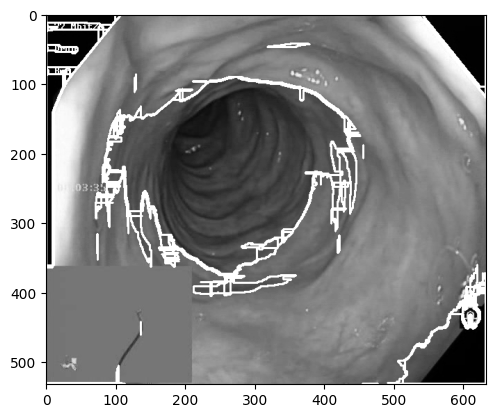

In [16]:
plt.imshow(np.array(image),cmap="gray", vmin=0, vmax=255);

### Trying to removing the box - Attempt 2

In [8]:
image = train_normal[0]

In [10]:
thresh = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV,51,9)

In [11]:
# Fill rectangular contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(thresh, [c], -1, (255,255,255), -1)

# Morph open
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)

# Draw rectangles, the 'area_threshold' value was determined empirically
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
area_treshold = 4000
for c in cnts:
    if cv2.contourArea(c) > area_treshold :
      x,y,w,h = cv2.boundingRect(c)
      cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 3)

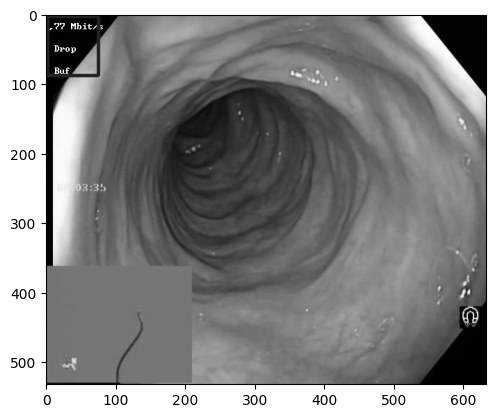

In [12]:
plt.imshow(np.array(image),cmap="gray", vmin=0, vmax=255);

### Trying to removing the box - Attempt 3 [Identifying squares/rectangles approach]

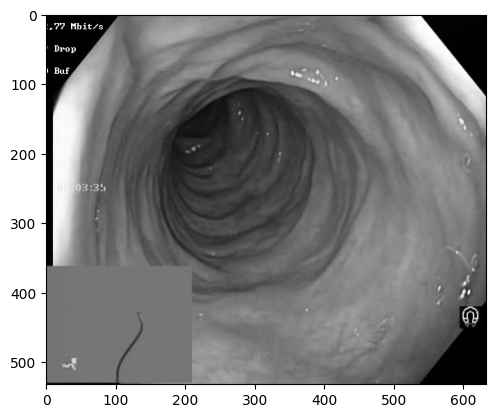

In [8]:
image = train_normal[0]
plt.imshow(np.array(image),cmap="gray", vmin=0, vmax=255);

In [11]:
ret,thresh = cv2.threshold(image,12,255,0)
contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,
                                      cv2.CHAIN_APPROX_SIMPLE)
print("Number of contours detected:", len(contours))

Number of contours detected: 58


In [15]:
# cnt = contours[4]
# x = cv2.drawContours(image, [cnt], 0, (0,255,0), 3)

In [21]:
for cnt in contours:
   x1,y1 = cnt[0][0]
   approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt, True), True)
   if len(approx) == 4:
      x, y, w, h = cv2.boundingRect(cnt)
      ratio = float(w)/h
      if ratio >= 0.9 and ratio <= 1.1:
         img = cv2.drawContours(image, [cnt], -1, (128,128,128), 3)
         cv2.putText(img, 'Square', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
      else:
         cv2.putText(img, 'Rectangle', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
         img = cv2.drawContours(image, [cnt], -1, (128,128,128), 3)

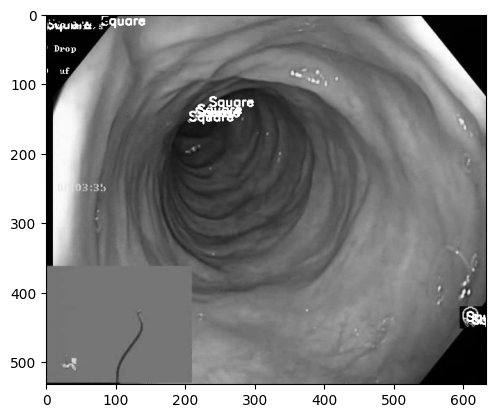

In [22]:
plt.imshow(image,cmap="gray", vmin=0, vmax=255);

### Trying to removing the box - Attempt 4 [Using blurring, canny and identifying contours]

In [20]:
image = train_normal[2]
# plt.imshow(np.array(image));

In [21]:
image.shape

(531, 631, 3)

In [14]:
blurred = cv2.GaussianBlur(image,(201,201),2)
Canny = cv2.Canny(blurred,50,60)

In [8]:
contours =cv2.findContours(Canny,cv2.RETR_EXTERNAL,
                           cv2.CHAIN_APPROX_SIMPLE)[0]

In [ ]:
cntrRect = []
for i in contours:
#     if cv2.contourArea(i) > 5: 
    epsilon = 0.05*cv2.arcLength(i,True)
    approx = cv2.approxPolyDP(i,epsilon,True)
    if len(approx) == 4:
        cv2.drawContours(image,cntrRect,-1,(0,255,0),2)
        cv2.imshow('Recognised rectangles',image)
        cntrRect.append(approx)

cv2.waitKey(0)

In [10]:
cv2.destroyAllWindows()

## Re-size and normalize images

In [9]:
def resize_norm(images):
    
    proc_images = []
    
    for image in images:
        resized_image = cv2.resize(image, (224,224))
        norm_image = resized_image / 255
        proc_images.append(norm_image)
    
    return proc_images

In [10]:
norm_preproc = resize_norm(train_normal)

In [11]:
norm_preproc[0].shape

(224, 224, 3)

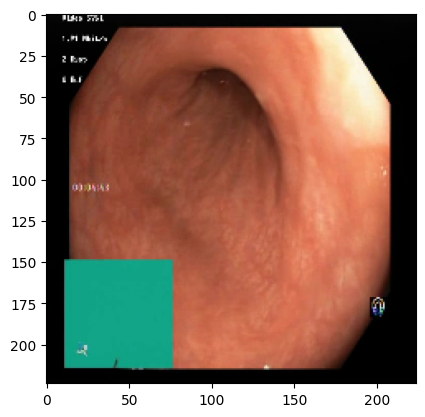

In [16]:
plt.imshow(norm_preproc[25]);

## Just resize

For the purpose of removing ROI

In [6]:
def resize_only(images):
    
    resize_images = []
    
    for image in images:
        temp = cv2.resize(image, (224,224))
        resize_images.append(temp)
    
    return resize_images

In [7]:
norm_resize = resize_only(train_normal)

## Removing a region of interest from the image [On Resized images]

### Using Threshold, Canny and contour to identify edges

In [12]:
image = norm_resize[13]
imgCopy = image.copy()
# imgCopy = image.astype(np.uint8)

Issues with some images: e.g., 3, 25

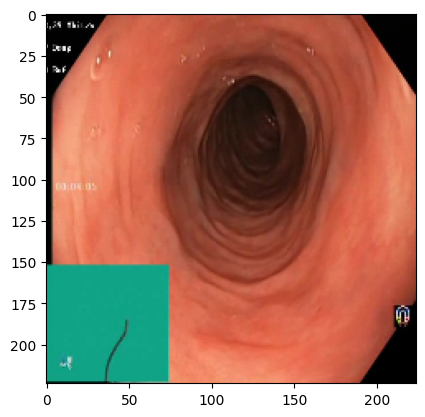

In [13]:
plt.imshow(imgCopy);

In [14]:
# blurred version & edge detection
blurred = cv2.GaussianBlur(imgCopy,(101,101),2)
edged = cv2.Canny(blurred,73,73*3) # 77, 225 best for now

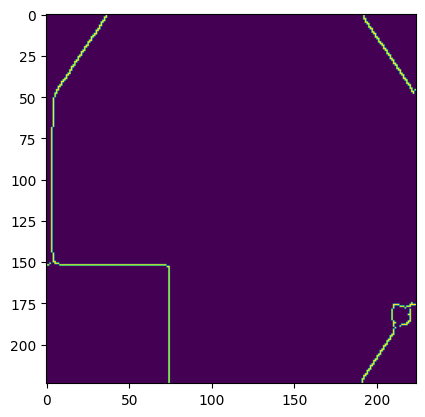

In [15]:
plt.imshow(edged);

In [16]:
# create the kernel to go through the image and dilate the edges
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
dilate = cv2.dilate(edged, kernel, iterations=1)

In [17]:
# find the contours of the identified edges
contours = cv2.findContours(dilate,cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

In [18]:
# draw contours on copy of image
image_copy = imgCopy.copy()
cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 2)
print(len(contours), "objects were found in this image.")

cv2.imshow("Dilated image", dilate)
cv2.imshow("contours", image_copy)
cv2.waitKey(0)

3 objects were found in this image.


In [75]:
cv2.destroyAllWindows()

In [72]:
# select 2 largest contours
select_cont = sorted(contours, key=cv2.contourArea, reverse=True)[:3]

In [73]:
len(select_cont)

3

In [74]:
copy_again = imgCopy.copy()
cv2.drawContours(copy_again, select_cont, -1, (0, 255, 0), 1)

cv2.imshow("contours", image_copy)
cv2.imshow("select contours", copy_again)
cv2.waitKey(0)

226

In [52]:
cv2.destroyAllWindows()

In [ ]:
# for contour in contours:
#     [x,y,w,h] = cv2.boundingRect(select_cont)

#     cv2.imshow("box extracted", img[y:y+h, x:x+w])
#     cv2.waitKey(0)

In [53]:
cntrRect = []
for i in select_cont:
    if cv2.contourArea(i) > 5: 
        epsilon = 0.05*cv2.arcLength(i,True)
        approx = cv2.approxPolyDP(i,epsilon,True)
        if len(approx) == 4:
            cv2.drawContours(copy_again,cntrRect,-1,(0,255,0),2)
            cv2.imshow('Recognised rectangles',copy_again)
            cntrRect.append(approx)

cv2.waitKey(0)

-1

In [35]:
cv2.destroyAllWindows()

### Skimage

In [75]:
from skimage.io import imshow
from skimage.filters import median, gaussian, threshold_otsu, sobel
from skimage.morphology import dilation, area_closing, binary_erosion
from scipy.ndimage import median_filter

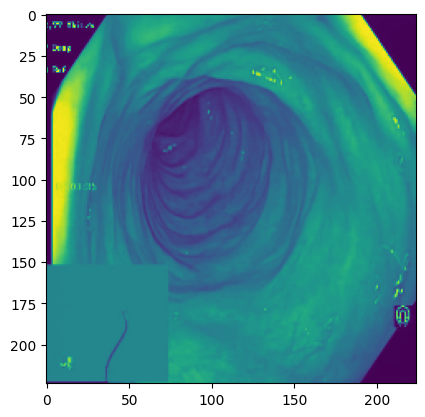

In [74]:
image = norm_resize[0]
imgCopy = image.astype(np.uint8)
plt.imshow(imgCopy);

In [76]:
edge_sobel = sobel(imgCopy)

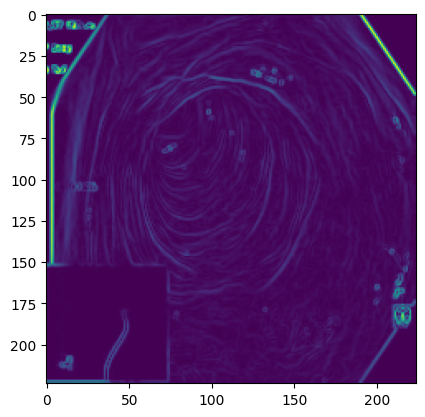

In [77]:
plt.imshow(edge_sobel)

In [17]:
# create inverse threshold
# thresh = cv2.threshold(imgCopy,128,255,
#                        cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

In [18]:
ROI_number = 0
contours = cv2.findContours(imgCopy,cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]

In [16]:
for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(imgCopy, (x, y), (x + w, y + h), (36,255,12), 2)
    ROI = imgCopy[y:y+h, x:x+w]
#     cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
    ROI_number += 1

cv2.imshow('image', imgCopy)
cv2.waitKey(0)

225

In [19]:
cntrRect = []
for i in contours:
#     if cv2.contourArea(i) > 5: 
    epsilon = 0.05*cv2.arcLength(i,True)
    approx = cv2.approxPolyDP(i,epsilon,True)
    if len(approx) == 4:
        cv2.drawContours(imgCopy,cntrRect,-1,(0,255,0),2)
        cv2.imshow('Recognised rectangles',imgCopy)
        cntrRect.append(approx)

cv2.waitKey(0)

225

## Adding a box in a ROI instead

In [14]:
# Identify ROI
y1 = 148
y2 = 224
x1 = 0
x2 = 77

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


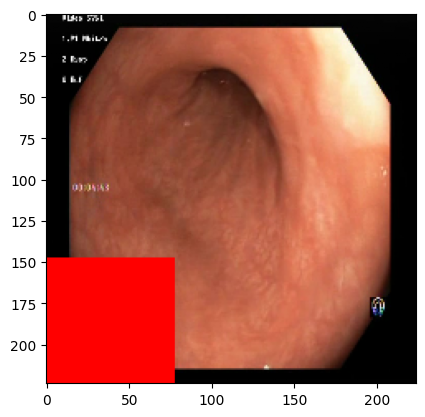

In [15]:
# adding a rectangle to the resized image
image = norm_preproc[25]
imgCopy = image.copy()
rect = cv2.rectangle(imgCopy, (x1,y1), (x2,y2),(255,0,0),-1)

plt.imshow(rect);

In [16]:
# Adding a rectangle to the resized and normalized image (-1 box)
image = norm_preproc[25]
imgCopy = image.copy()

In [17]:
rect = cv2.rectangle(imgCopy, (x1,y1), (x2,y2),(-1,-1,-1),-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


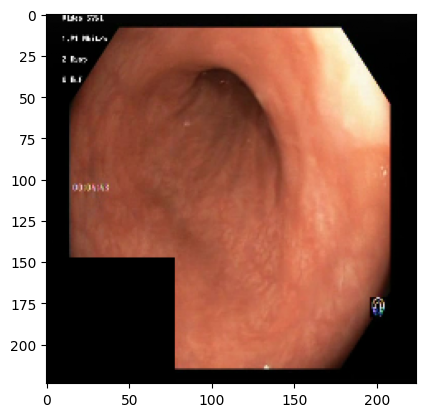

In [18]:
plt.imshow(rect);

In [16]:
unique, counts = np.unique(rect, return_counts=True)
print(np.asarray((unique,counts)).T)

[[-1.00000000e+00  1.77840000e+04]
 [ 0.00000000e+00  2.65700000e+03]
 [ 3.92156863e-03  2.96800000e+03]
 [ 7.84313725e-03  1.63000000e+03]
 [ 1.17647059e-02  6.19000000e+02]
 [ 1.56862745e-02  2.44000000e+02]
 [ 1.96078431e-02  1.68000000e+02]
 [ 2.35294118e-02  1.23000000e+02]
 [ 2.74509804e-02  8.50000000e+01]
 [ 3.13725490e-02  7.40000000e+01]
 [ 3.52941176e-02  8.40000000e+01]
 [ 3.92156863e-02  1.07000000e+02]
 [ 4.31372549e-02  1.37000000e+02]
 [ 4.70588235e-02  2.05000000e+02]
 [ 5.09803922e-02  2.78000000e+02]
 [ 5.49019608e-02  3.17000000e+02]
 [ 5.88235294e-02  3.42000000e+02]
 [ 6.27450980e-02  4.54000000e+02]
 [ 6.66666667e-02  4.55000000e+02]
 [ 7.05882353e-02  4.56000000e+02]
 [ 7.45098039e-02  4.13000000e+02]
 [ 7.84313725e-02  4.33000000e+02]
 [ 8.23529412e-02  4.14000000e+02]
 [ 8.62745098e-02  5.10000000e+02]
 [ 9.01960784e-02  4.87000000e+02]
 [ 9.41176471e-02  4.79000000e+02]
 [ 9.80392157e-02  4.93000000e+02]
 [ 1.01960784e-01  4.85000000e+02]
 [ 1.05882353e-01  4

## Remove text from images

In [1]:
import keras_ocr

2023-03-09 11:07:44.130294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 11:07:44.253761: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mai/.pyenv/versions/3.10.6/envs/GI_disease_detection/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-09 11:07:44.253782: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-09 11:07:44.922901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load d